# Analysis of Ensemble-Based Criticality Scores

**Objective:** To load the criticality scores generated by `score_criticality_ensemble.py`
and visualize them alongside the corresponding scenario animation. This serves as a
sanity check to ensure our "model disagreement" metric is correctly identifying
complex or ambiguous situations.

In [1]:
# ## 1. Setup and Configuration
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random
from IPython.display import display, clear_output

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.data_processing.validate_parser_output import visualize_scenario

# Load project config and set plot style
config = load_config(config_path='../configs/main_config.yaml')
sns.set_theme(style="whitegrid")

print("Setup Complete.")

Configuration loaded successfully.
Setup Complete.


In [2]:
# ## 2. Load a Random Scenario and its Score
# 
# This cell loads the data for a single, randomly chosen scenario. Run this cell whenever you want to analyze a new scenario.

# +
# --- Global variables to hold the currently loaded data ---
CURRENT_SCENARIO_ID = None
CURRENT_SCORE_DATA = None
CURRENT_RAW_DATA_PATH = None

def load_new_random_scenario():
    """Loads a new scenario into the global variables."""
    global CURRENT_SCENARIO_ID, CURRENT_SCORE_DATA, CURRENT_RAW_DATA_PATH
    
    # --- Define Paths ---
    # Path to the ENSEMBLE scores
    scores_dir = os.path.join(config['data']['criticality_scores_dir'], 'timestep_level', 'ensemble', 'validation')
    # Path to the original PROCESSED data needed for video
    raw_data_dir = os.path.join(config['data']['processed_npz_dir'], 'validation')
    
    all_score_files = glob(os.path.join(scores_dir, '*.npz'))
    if not all_score_files:
        raise FileNotFoundError(f"No ensemble score files found in {scores_dir}. Please run the script first.")

    # --- Load Data for a Random Scenario ---
    random_score_file_path = random.choice(all_score_files)
    
    base_filename = os.path.basename(random_score_file_path)
    CURRENT_SCENARIO_ID = base_filename.split('.')[0]
    
    CURRENT_RAW_DATA_PATH = os.path.join(raw_data_dir, f"{CURRENT_SCENARIO_ID}.npz")

    if not os.path.exists(CURRENT_RAW_DATA_PATH):
        print(f"ERROR: Raw data file for {CURRENT_SCENARIO_ID} not found. Trying another.")
        load_new_random_scenario() # Recursively try again
        return

    CURRENT_SCORE_DATA = np.load(random_score_file_path)
    print(f"--- Successfully Loaded Scenario: {CURRENT_SCENARIO_ID} ---")
    
# --- Initial Load ---
load_new_random_scenario()

--- Successfully Loaded Scenario: d1d0787fd3ed90a8 ---


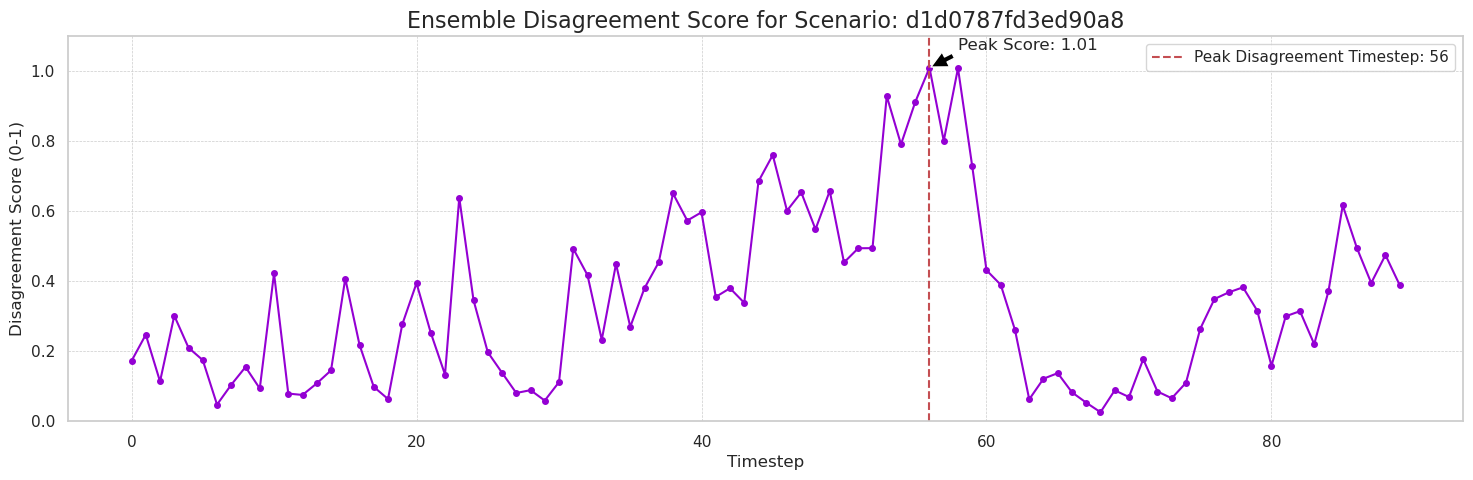

The moment of highest model disagreement occurs at timestep 56.


In [3]:
# ## 3. Plot the Ensemble Disagreement Score Over Time
# 
# This plot will show us where the "confusing" moments are, according to the scout models.

# +
def plot_ensemble_scores():
    if CURRENT_SCORE_DATA is None:
        print("Please run the cell above to load a scenario first.")
        return
        
    # The score file contains one key: 'ensemble'
    scores = CURRENT_SCORE_DATA['ensemble']
    
    fig, ax = plt.subplots(figsize=(18, 5))
    timesteps = np.arange(len(scores))
    ax.plot(timesteps, scores, marker='o', linestyle='-', markersize=4, color='darkviolet')
    ax.set_title(f'Ensemble Disagreement Score for Scenario: {CURRENT_SCENARIO_ID}', fontsize=16)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Disagreement Score (0-1)')
    ax.set_ylim(0, 1.1)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Highlight the most critical timestep
    most_critical_timestep = np.argmax(scores)
    peak_score = np.max(scores)
    ax.axvline(x=most_critical_timestep, color='r', linestyle='--', label=f'Peak Disagreement Timestep: {most_critical_timestep}')
    ax.annotate(f'Peak Score: {peak_score:.2f}', 
                xy=(most_critical_timestep, peak_score), 
                xytext=(most_critical_timestep + 2, peak_score + 0.05),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12)

    plt.legend()
    plt.show()
    
    print(f"The moment of highest model disagreement occurs at timestep {most_critical_timestep}.")

# --- Plot for the currently loaded scenario ---
plot_ensemble_scores()

In [4]:
# ## 4. Generate Video for Visual Verification
# 
# Let's watch the video. Pay close attention to the timestep with the highest score.
# 
# **Expected Behavior:** Around the peak score timestep, you should observe a situation that is not necessarily a near-crash, but is **ambiguous or complex**. Examples include:
# - An unprotected left turn with oncoming traffic.
# - A four-way stop with multiple agents arriving at once.
# - A pedestrian behaving erratically near the road.
# - A dense, interactive merge where multiple valid gaps exist.

# +
def generate_video_for_current_scenario():
    if CURRENT_RAW_DATA_PATH is None:
        print("No scenario loaded. Please run Cell #2 first.")
        return
        
    print(f"\nGenerating scenario animation for: {CURRENT_SCENARIO_ID}...")
    try:
        video_output_dir = 'outputs/ensemble_score_validation_videos'
        visualize_scenario(CURRENT_RAW_DATA_PATH, output_dir=video_output_dir)
        print(f"\n✅ Animation saved to '{video_output_dir}/{CURRENT_SCENARIO_ID}.mp4'")
    except Exception as e:
        print(f"\n❌ An error occurred during animation: {e}")

# --- Run this cell to generate the video for the scenario analyzed above ---
generate_video_for_current_scenario()


Generating scenario animation for: d1d0787fd3ed90a8...
Loading scenario from: /mnt/d/waymo_datasets/waymo_longtail_rl_data/processed_npz/validation/d1d0787fd3ed90a8.npz
Creating animation for timestep 0 to 90...
Animation saved to: outputs/ensemble_score_validation_videos/d1d0787fd3ed90a8.mp4

✅ Animation saved to 'outputs/ensemble_score_validation_videos/d1d0787fd3ed90a8.mp4'
